In [1]:
# Importing all the libraries needed
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
import pandas as pd
import os, requests, cv2, random
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input,Conv2D, MaxPooling2D, Flatten,Dense, Dropout, LayerNormalization, MultiHeadAttention, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import models
from tensorflow.keras import Sequential, layers
from keras.preprocessing.image import ImageDataGenerator
from tensorflow import keras
from sklearn.metrics import confusion_matrix,classification_report

import tensorflow
import os
import matplotlib.pyplot as plt
from PIL import Image
print(tensorflow. __version__) 

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


2.13.0


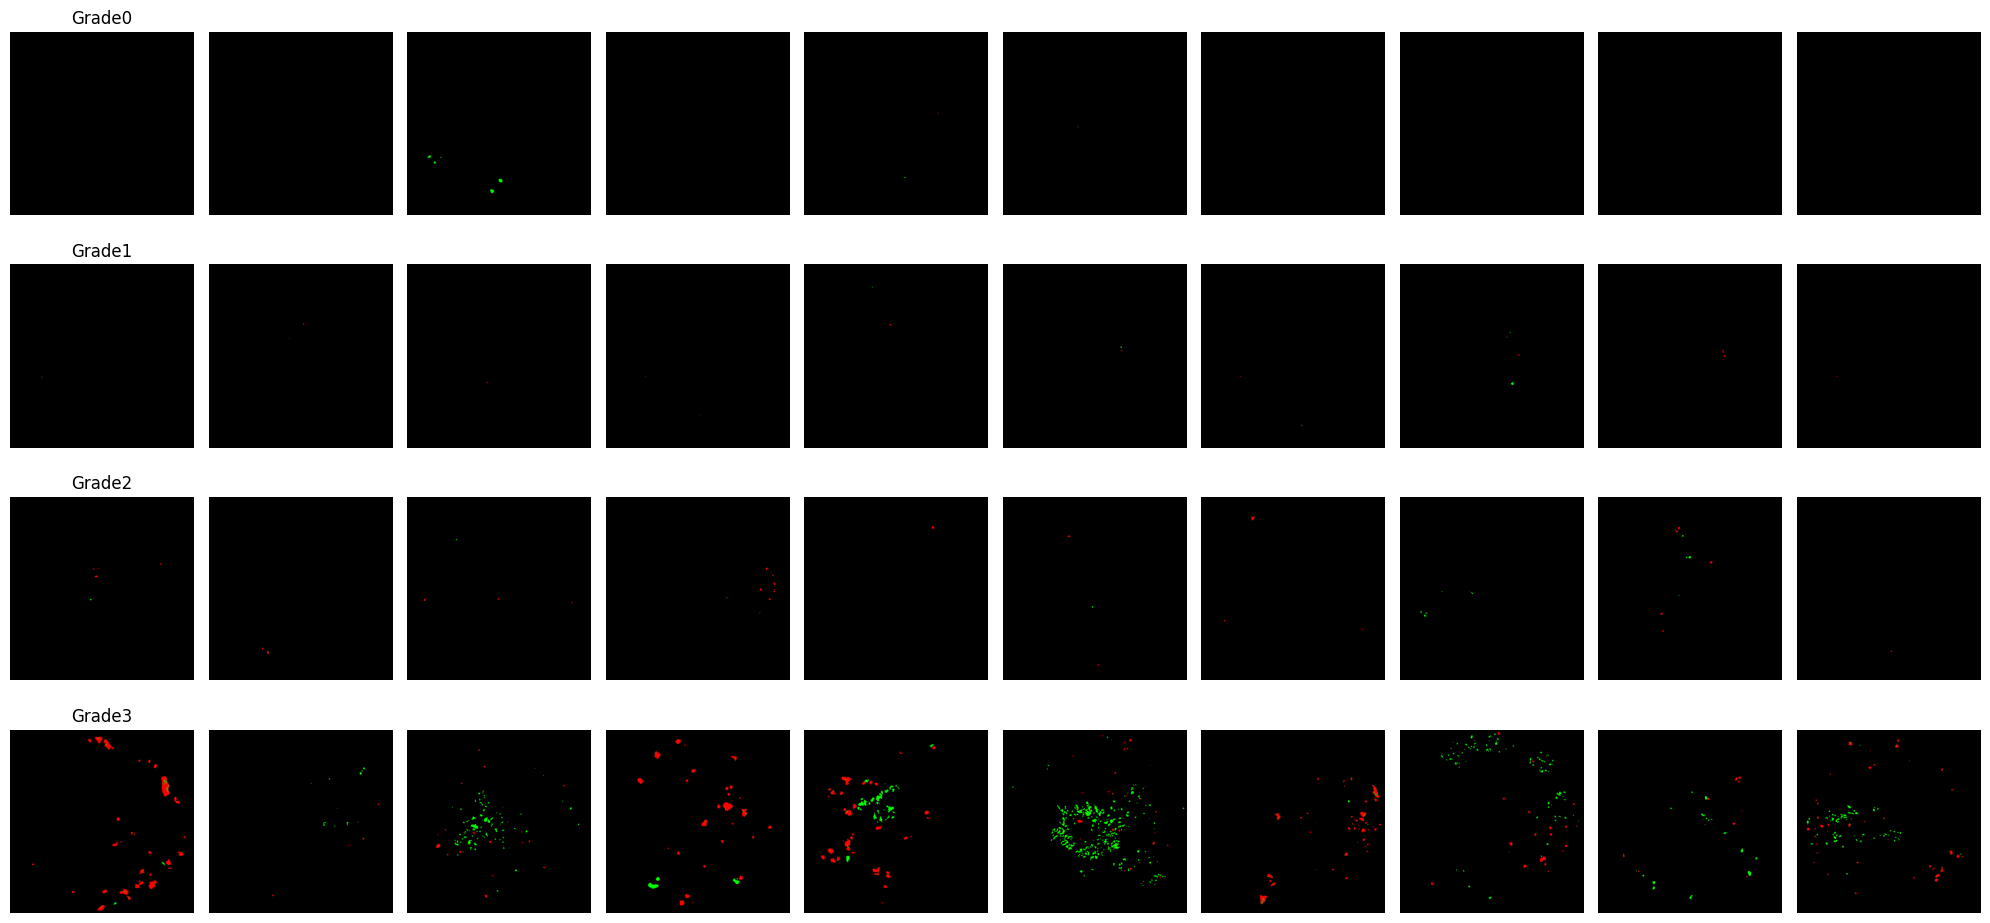

In [2]:


# Path to the directory containing class folders
data_dir = '/kaggle/input/retina/untitled folder/untitled folder/Train'

# Get a list of class folders
class_folders = sorted([folder for folder in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, folder))])

# Create subplots for each class
num_classes = len(class_folders)
fig, axs = plt.subplots(num_classes, 10, figsize=(20, 2.4*num_classes))

# Iterate through each class and its images
for i, class_folder in enumerate(class_folders):
    class_path = os.path.join(data_dir, class_folder)
    image_files = os.listdir(class_path)[:10]  # Assuming you want to display only 10 images per class
    
    # Iterate through the first 10 images in the class folder
    for j, image_file in enumerate(image_files):
        image_path = os.path.join(class_path, image_file)
        image = Image.open(image_path)
        
        # Display the image in the corresponding subplot
        axs[i, j].imshow(image)
        axs[i, j].axis('off')
    
    # Set the class name as the title of the row
    axs[i, 0].set_title(class_folder)

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

In [3]:
# loading the pictures of tomatoes

train_data_dir = '/kaggle/input/retina/untitled folder/untitled folder/Train'
test_data_dir = '/kaggle/input/retina/untitled folder/untitled folder/Validation' #this folder will be used for evaluating model's perfomance

In [4]:
# for this challenge we are using ImageDataGenerator 

train_datagen = ImageDataGenerator(rescale=1/255.0,
                               shear_range=0.2,
                                zoom_range=0.2,
                                horizontal_flip=True,
                                validation_split=0.3)# specifying the validation split inside the function

test_datagen = ImageDataGenerator(rescale=1/255.0,
                                shear_range=0.2,
                                zoom_range=0.2,
                                horizontal_flip=True)

In [5]:
train_gen = train_datagen.flow_from_directory(
                                train_data_dir,
                                target_size=(512, 512),
                                batch_size=32,
                                shuffle=True,
                                class_mode='categorical',
                                subset='training')

val_gen = train_datagen.flow_from_directory(
                                train_data_dir,
                                target_size=(512,512),
                                batch_size=32,
                                shuffle=True,
                                class_mode='categorical',
                                subset='validation')

Found 401 images belonging to 4 classes.
Found 170 images belonging to 4 classes.


In [6]:
test_gen = test_datagen.flow_from_directory(
        test_data_dir,
        target_size=(512, 512),
        batch_size=32,
        class_mode='categorical',
        shuffle = False) #shuffle will not affect the accuracy of the model, but will affect the computation of some metrics that depend on the order of the samples

Found 101 images belonging to 4 classes.


## Building a ViT model

In [7]:


def create_vision_transformer(input_shape, num_classes, d_model=1024, num_heads=4, ff_dim=512, dropout_rate=0.2):
    # Input layer
    inputs = Input(shape=input_shape)
    
    # Patch embeddings
    patch_size = 32
    patches = tf.keras.layers.Conv2D(d_model, kernel_size=patch_size, strides=patch_size, padding='valid')(inputs)
    num_patches = patches.shape[1] * patches.shape[2]  # Calculate the number of patches
    patch_dim = d_model
    
    # Positional embeddings
    positions = tf.range(start=0, limit=num_patches, delta=1)
    position_embeddings = tf.keras.layers.Embedding(input_dim=num_patches, output_dim=d_model)(positions)
    position_embeddings = tf.reshape(position_embeddings, shape=(-1, patches.shape[1], patches.shape[2], d_model))
    
    # Add positional embeddings to patches
    embeddings = patches + position_embeddings
    
    # Transformer Encoder layers
    for _ in range(num_heads):
        # Multi-Head Attention and Layer Normalization
        attn_output = MultiHeadAttention(num_heads=num_heads, key_dim=d_model // num_heads)(embeddings, embeddings)
        attn_output = Dropout(dropout_rate)(attn_output)
        embeddings = LayerNormalization(epsilon=1e-6)(embeddings + attn_output)
        
        # Feed Forward and Layer Normalization
        ff_output = Dense(ff_dim, activation='relu')(embeddings)
        ff_output = Dense(d_model)(ff_output)
        ff_output = Dropout(dropout_rate)(ff_output)
        embeddings = LayerNormalization(epsilon=1e-6)(embeddings + ff_output)
    
    # Global Average Pooling and Classifier
    avg_pooling = GlobalAveragePooling2D()(embeddings)
    outputs = Dense(num_classes, activation='softmax')(avg_pooling)
    
    # Create the model
    model = Model(inputs, outputs)
    return model

# Define input shape and number of classes
input_shape = (512, 512, 3)
num_classes = 4

# Create and compile the model
model = create_vision_transformer(input_shape, num_classes)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Print model summary
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 512, 512, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 16, 16, 1024)         3146752   ['input_1[0][0]']             
                                                                                                  
 tf.__operators__.add (TFOp  (None, 16, 16, 1024)         0         ['conv2d[0][0]']              
 Lambda)                                                                                          
                                                                                                  
 multi_head_attention (Mult  (None, 16, 16, 1024)         4198400   ['tf.__operators__.add[0][

In [8]:
es = EarlyStopping(monitor = 'val_accuracy', 
                   mode = 'max', 
                   patience = 10, 
                   verbose = 1, 
                   restore_best_weights = True)


history = model.fit(x = train_gen,
                    callbacks = [es], 
                    epochs = 25,
                    validation_data = val_gen)  

Epoch 1/25


2024-04-18 16:51:18.829106: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout_1/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


13/13 [==============================] - 63s 4s/step - loss: 4.6326 - accuracy: 0.3416 - val_loss: 1.6664 - val_accuracy: 0.2824
Epoch 2/25
13/13 [==============================] - 46s 4s/step - loss: 1.1511 - accuracy: 0.5037 - val_loss: 1.2258 - val_accuracy: 0.6294
Epoch 3/25
13/13 [==============================] - 46s 4s/step - loss: 0.8385 - accuracy: 0.6584 - val_loss: 0.7688 - val_accuracy: 0.6588
Epoch 4/25
13/13 [==============================] - 46s 4s/step - loss: 0.6692 - accuracy: 0.7706 - val_loss: 0.9707 - val_accuracy: 0.7118
Epoch 5/25
13/13 [==============================] - 46s 4s/step - loss: 0.7891 - accuracy: 0.7307 - val_loss: 0.6594 - val_accuracy: 0.7824
Epoch 6/25
13/13 [==============================] - 46s 4s/step - loss: 0.8051 - accuracy: 0.7057 - val_loss: 1.0586 - val_accuracy: 0.6824
Epoch 7/25
13/13 [==============================] - 46s 4s/step - loss: 0.8940 - accuracy: 0.7207 - val_loss: 1.2297 - val_accuracy: 0.6000
Epoch 8/25
13/13 [=============

## Model Evaluation

In [9]:
scores = model.evaluate(test_gen)
model.save('retina_ViT.h5')

4/4 [==============================] - 9s 2s/step - loss: 0.5828 - accuracy: 0.7921


/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


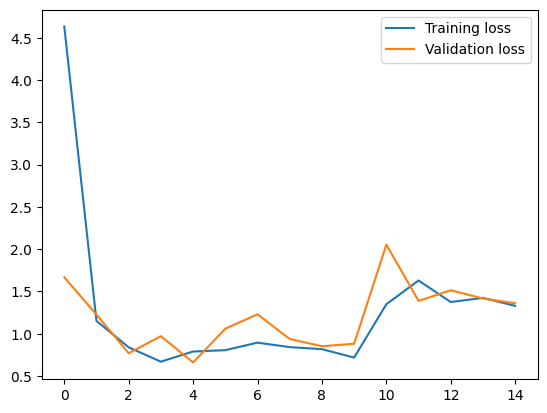

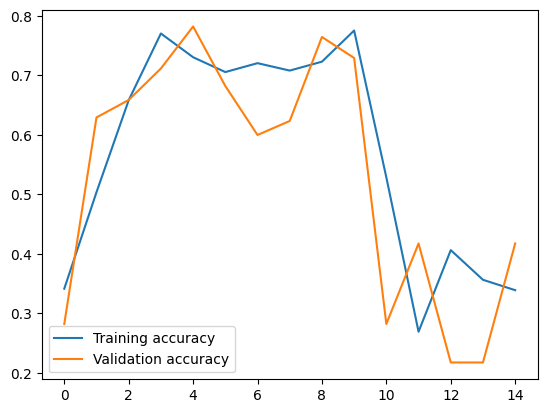

In [10]:
# plot the loss
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()
plt.show()

# plot the accuracy
plt.plot(history.history['accuracy'], label='Training accuracy')
plt.plot(history.history['val_accuracy'], label='Validation accuracy')
plt.legend()
plt.show()

## confusion matrix, metrics.

In [11]:
test_steps_per_epoch = np.math.ceil(test_gen.samples / test_gen.batch_size)
predictions = model.predict(test_gen, steps=test_steps_per_epoch)
predicted_classes = np.argmax(predictions,axis=1)

true_classes = test_gen.classes
class_labels = list(test_gen.class_indices.keys())

4/4 [==============================] - 9s 2s/step


In [12]:
# Print confusion matrix
confusion_matrix = confusion_matrix(test_gen.classes, predicted_classes)
print(confusion_matrix)

[[44  0  0  0]
 [ 4  0  6  0]
 [ 0  0 13  8]
 [ 0  0  1 25]]


In [13]:
# To check F1 score, recall etc.
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report)

              precision    recall  f1-score   support

      Grade0       0.92      1.00      0.96        44
      Grade1       0.00      0.00      0.00        10
      Grade2       0.65      0.62      0.63        21
      Grade3       0.76      0.96      0.85        26

    accuracy                           0.81       101
   macro avg       0.58      0.65      0.61       101
weighted avg       0.73      0.81      0.77       101



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
